In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from statsmodels.graphics.gofplots import qqplot
from src.kalman_predictor import *

# df = pd.read_csv("../data/TAQ_30Min_AAPL_2023_normalized.csv")
# df.index = df.datetime

df = pd.read_excel("data/TICKER_TURNOVERS_COMBINED.xlsx")
df = df[df['TICKER'] == 'AAPL']
df['date'] = pd.to_datetime(df['date'])
dates_to_remove = pd.to_datetime(['2023-02-22', '2023-03-15'])
df = df[~df['date'].isin(dates_to_remove)]

df["Log_Turnover"] = np.log(df["Normalized_TURNOVER"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1596 entries, 0 to 1609
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1596 non-null   datetime64[ns]
 1   time                 1596 non-null   object        
 2   TICKER               1596 non-null   object        
 3   TURNOVER             1596 non-null   float64       
 4   Normalized_TURNOVER  1596 non-null   float64       
 5   Log_Turnover         1596 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 87.3+ KB


## Preliminary: QQ plot
Since the Kalman filter paper has one

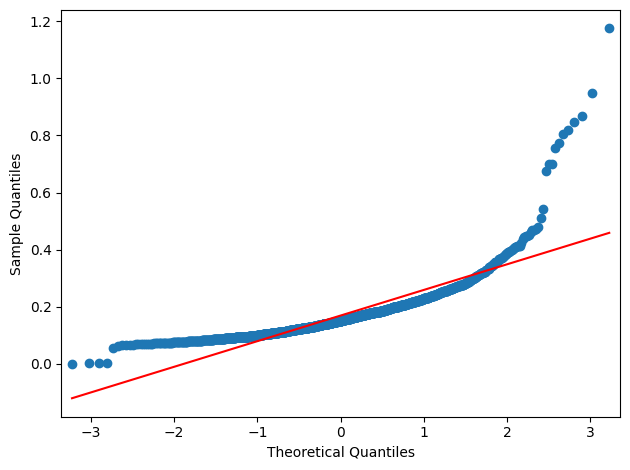

<Figure size 640x480 with 0 Axes>

In [31]:
qq_nolog = qqplot(df["Normalized_TURNOVER"], line="s")
plt.tight_layout()
plt.show()
plt.savefig("nolog_qqplot.pdf")

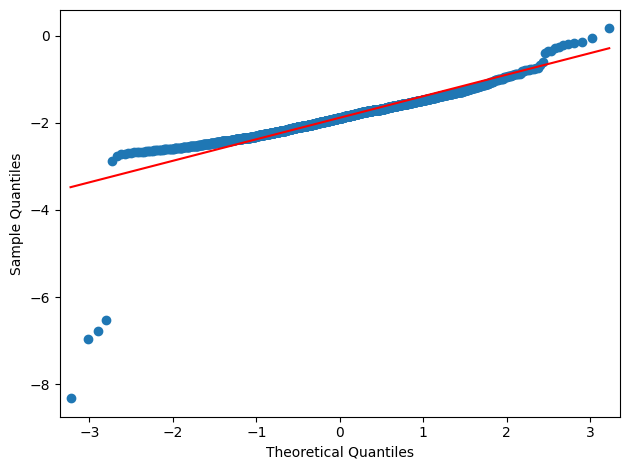

<Figure size 640x480 with 0 Axes>

In [32]:
qq_log = qqplot(np.log(df["Normalized_TURNOVER"]), line="s")
plt.tight_layout()
plt.show()
plt.savefig("log_qqplot.pdf")

In [9]:
C = np.ones((1,2))
C.shape

(1, 2)

## Kalman filtering

In [36]:
# set up and run a dimensional test
y_1 = df.head(1)["Log_Turnover"]
x_1 = np.reshape(np.array([y_1/2, y_1/2]), 2)
Sigma_1 = np.eye(2)

theta = Params(x_1, np.identity(2)*0.5, 1.0, 1.0, 0.0025, 0.0025, 0.0005, np.array([0.6, 0.25, 0.0, -0.15, -0.3, -0.45, -0.5, -0.6, -0.5, -0.25, -0.3, -0.1, 0.4]))
predictor = KalmanPredictor(theta)

y_plus = predictor.predict_alike(y_1, x_t=x_1, start_time=0)
# print("Shape should be {}: x.shape = {}".format(1, x_plus.shape))

## Kalman smoothing

In [37]:
ys = df["Log_Turnover"].to_numpy()

N_train = 50

x_tau_n, Sigma_tau_n, _, _, _ = kalman_smoothing(x_1, ys[0:N_train], Sigma_1, theta)
# dimensional check again
print(x_tau_n.shape)
print(Sigma_tau_n.shape)

(2, 1)
(2, 2)


## Expectation maximization
In this step we want to predict $x_\tau = [\eta_\tau\ \mu_\tau]^\top \in \mathbb{R}^2$ which is the hidden state vector. The variables $\eta_\tau$ and $\mu_\tau$ are the daily average and intraday dynamic part of the log volume.

In [38]:
test_params = em(x_1, ys[1:N_train*13], theta, maxsteps=25, tol=0.05)

N = 649, N_days=49
0 first step done 648
	pi, sigma = [[-1.23157818]
 [-1.23157818]], [[-0.68494102 -1.18744102]
 [-1.18744102 -0.68494102]]
	a_eta = 0.9998567269623236, a_mu = 1.0021730513251994
	sigma_eta_sq = 0.008697721954633331, sigma_mu_sq = -4.562063590717943e-05
	r = 0.33237549619616663, phi = [-0.35525597 -0.30661372 -0.3522401  -0.38869039 -0.35572867 -0.31213136
 -0.28729365 -0.3208426  -0.33731641 -0.37528678 -0.30893982 -0.31679507
 -0.34154407]
0 second step done
0, Error=0.2635303330203073
1 first step done 648
	pi, sigma = [[-0.84778363]
 [-0.84927708]], [[-0.03420153 -0.53260002]
 [-0.53260002 -0.02331403]]
	a_eta = 0.9995107432774127, a_mu = 1.001016488510589
	sigma_eta_sq = 0.016551804182539615, sigma_mu_sq = -6.604301954910628e-06
	r = 0.22170935358288732, phi = [-0.56145086 -0.51305831 -0.5623291  -0.59808203 -0.56498929 -0.52105146
 -0.49915217 -0.5365639  -0.55558051 -0.59421512 -0.52744922 -0.52127091
 -0.54531813]
1 second step done
1, Error=0.17119148883294336

In [39]:
predictor = KalmanPredictor(test_params) # we already trained them in the previous cell, holdover from previous code

## Test Kalman filter with given params

In [40]:
N = df["Log_Turnover"].size

In [41]:
y_t = df.iloc[0:1]["Log_Turnover"]
x_t = np.reshape(np.array([y_t/2, y_t/2]), 2)
xs = [x_t,]

Sigma_t = np.identity(2)
sigmas = [Sigma_t,]

y_pred = [y_t]
y_pred = predictor.predict_alike(df["Log_Turnover"])

In [42]:
errs = [np.mean(np.square(y_pred[i] - df.iloc[i:i+1]["Log_Turnover"])) for i in range(N)]

In [43]:
y_t = df.iloc[0:1]["Log_Turnover"]
x_t = np.reshape(np.array([y_t/2, y_t/2]), 2)

Sigma_t = np.identity(2)

y_pred_new = [y_t]
I = 13
for i in range(N):
    y_t = df.iloc[i:i+1]["Log_Turnover"]
    x_plus, Sigma_plus = kalman_filtering(i, x_t, y_t, Sigma_t, test_params)
    y_pred_new.append((C@x_plus)[0] + test_params.phi[i%I])

In [44]:
errs_new = [np.mean(np.square(y_pred_new[i] - df.iloc[i:i+1]["Log_Turnover"])) for i in range(N)]

### Comparison: hourly average over the year

In [47]:
log_avgs = np.log(df["Hourly averages"])
errs_avg = [np.mean(np.square(log_avgs - df.iloc[i:i+1]["Log_Turnover"])) for i in range(N)]

ValueError: cannot reshape array of size 1596 into shape (122,13)

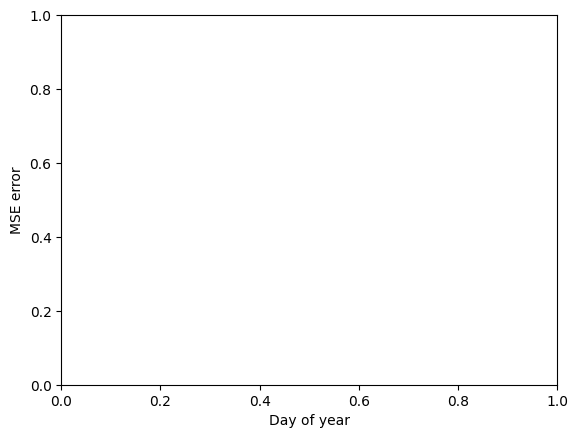

In [48]:
#plt.semilogy(np.mean(np.reshape(errs, (int(len(errs)/I), I)), axis=1), label="Average daily prediction error")
plt.xlabel("Day of year"); plt.ylabel("MSE error")
plt.semilogy(np.mean(np.reshape(errs_new, (int(len(errs_new)/I), I)), axis=1), label="Daily prediction error (Kalman)")
plt.semilogy(np.mean(np.reshape(errs_avg, (int(len(errs_avg)/I), I)), axis=1), linestyle="--", label="Daily prediction error (average)")

plt.legend()
plt.savefig("kalman_errors_year.pdf")
print("Average error: {}".format(np.mean(errs_avg)))
print("Kalman error: {}".format(np.mean(errs_new)))

In [ ]:
fig, axs = plt.subplots(5, sharex=True, figsize=(5,7))

axs[0].semilogy(np.exp(y_pred_new[-I:]),label="Predicted turnover (Kalman)", linestyle="-.", color="cornflowerblue")
axs[0].plot(np.exp(df.iloc[-I:]["Log_Turnover"].to_numpy()), label="True normalized turnover", color="black")
axs[0].plot(df.iloc[-I:]["Hourly averages"].to_numpy(), label="Predicted turnover (mean)", color="orange", linestyle="--")

for i in range(1,5):
    axs[i].semilogy(np.exp(y_pred_new[-I*(i+1):-I*i]), linestyle="-.", color="cornflowerblue")
    axs[i].plot(np.exp(df.iloc[-(i+1)*I:-i*I]["Log_Turnover"].to_numpy()), color="black")
    axs[i].plot(df.iloc[-(i+1)*I:-i*I]["Hourly averages"].to_numpy(), color="orange", linestyle="--")

daily_labels = ["9:30", "10:30", "11:30", "12:30", "13:30", "14:30", "15:30",]
plt.xticks(ticks=range(0, I, 2), labels=daily_labels)
fig.legend(loc="upper center"); plt.ylabel("Normalized turnover")
fig.tight_layout()
fig.savefig("kalman_prediction.pdf")